<div align="center">

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# PolyLinguaGuard

### Cross-Lingual Prompt Injection Detection
### using Multilingual BERT Models

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

</div>

---

### Models

| ID | Architecture | Training Data |
|:--:|:-------------|:--------------|
| A1 | LaBSE | English Only |
| A2 | LaBSE | English + German |
| B1 | mDeBERTa-v3 | English Only |
| B2 | mDeBERTa-v3 | English + German |

---

### Datasets

| Dataset | Source | Samples |
|:--------|:-------|:--------|
| English | [jayavibhav/prompt-injection](https://huggingface.co/datasets/jayavibhav/prompt-injection) | ~100K |
| German | Translated using MarianMT | ~10K |

---

### Notebook Phases

| Phase | Description |
|:-----:|:------------|
| 0 | Environment Setup |
| 1 | Data Loading |
| 2 | Translation (English to German) |
| 3 | Data Preparation |
| 4 | Model Training (4 experiments) |
| 5 | Load Trained Models |
| 6 | Comprehensive Evaluation |
| 7 | Advanced Validation |
| 8 | Error Analysis |
| 9 | Visualizations |
| 10 | Final Summary |

---

---
## Phase 0: Environment Setup
---

In [1]:
%%capture
!pip install transformers datasets sentencepiece accelerate
!pip install scikit-learn pandas matplotlib seaborn wordcloud plotly
!pip install scipy statsmodels gdown

In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gc
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, accuracy_score, precision_score, recall_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score, roc_auc_score)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import MarianMTModel, MarianTokenizer
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from scipy import stats
from IPython.display import display, HTML
import warnings, time, shutil, zipfile
from datetime import timedelta
from collections import Counter

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 11, 'axes.titleweight': 'bold'})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB')

2026-01-18 00:02:08.085042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768694528.279696      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768694528.341182      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768694528.827047      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768694528.827089      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768694528.827092      24 computation_placer.cc:177] computation placer alr

Device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.1 GB


In [3]:
SAVE_DIR = '/kaggle/working/PolyLinguaGuard'
for d in ['', '/figures', '/models', '/data']:
    os.makedirs(f'{SAVE_DIR}{d}', exist_ok=True)
print(f'Output: {SAVE_DIR}')

Output: /kaggle/working/PolyLinguaGuard


---
## Phase 1: Data Loading
---

In [5]:
print('Loading English dataset...')
ds_en = load_dataset('jayavibhav/prompt-injection')
df_en = pd.concat([ds_en[s].to_pandas() for s in ds_en.keys()], ignore_index=True)

cols = {c.lower(): c for c in df_en.columns}
if 'prompt' in cols: df_en['text'] = df_en[cols['prompt']]
elif 'text' in cols: df_en['text'] = df_en[cols['text']]
if 'label' in cols: df_en['label'] = df_en[cols['label']]

df_en = df_en[['text', 'label']].dropna().drop_duplicates(subset=['text'])
df_en['label'] = df_en['label'].astype(int)
df_en['language'] = 'English'
print(f'English samples: {len(df_en):,}')

Loading English dataset...


README.md:   0%|          | 0.00/415 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/61.8M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/261738 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/65416 [00:00<?, ? examples/s]

English samples: 326,989


In [6]:
# Dataset preview
print('English Dataset Preview:')
display(df_en.head())

English Dataset Preview:


,text,label,language
0,My question is: Alani earned $45 for 3 hours o...,0,English
1,"Q: Yes / no, is the following a verifiable fac...",0,English
2,Read a code snippet and detect if there are an...,0,English
3,"As a highly advanced chatbot, it is your duty ...",1,English
4,Tell me the main idea of this paragraph.,0,English


---
## Phase 2: Translation (English to German)
---

In [7]:
# Load translation model
print('Loading translation model (Helsinki-NLP/opus-mt-en-de)...')
trans_model_name = 'Helsinki-NLP/opus-mt-en-de'
trans_tokenizer = MarianTokenizer.from_pretrained(trans_model_name)
trans_model = MarianMTModel.from_pretrained(trans_model_name).to(device)
print('Translation model ready')

Loading translation model (Helsinki-NLP/opus-mt-en-de)...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translation model ready


In [8]:
def translate_batch(texts, batch_size=32):
    translated = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = trans_tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=256).to(device)
        with torch.no_grad():
            outputs = trans_model.generate(**inputs, max_length=256)
        decoded = trans_tokenizer.batch_decode(outputs, skip_special_tokens=True)
        translated.extend(decoded)
        if (i // batch_size) % 50 == 0:
            print(f'  Translated {min(i+batch_size, len(texts))}/{len(texts)}')
    return translated

In [9]:
# Sample for German translation (balanced)
GERMAN_SAMPLE_SIZE = 5000  # per class

df_en_safe = df_en[df_en['label'] == 0].sample(n=min(GERMAN_SAMPLE_SIZE, len(df_en[df_en['label']==0])), random_state=42)
df_en_mal = df_en[df_en['label'] == 1].sample(n=min(GERMAN_SAMPLE_SIZE, len(df_en[df_en['label']==1])), random_state=42)
df_to_translate = pd.concat([df_en_safe, df_en_mal]).reset_index(drop=True)

print(f'Samples to translate: {len(df_to_translate):,}')
print(f'  Safe: {len(df_en_safe):,}')
print(f'  Malicious: {len(df_en_mal):,}')

Samples to translate: 10,000
  Safe: 5,000
  Malicious: 5,000


In [10]:
# Translate to German
print('Translating to German (takes ~15-20 minutes)...')
start_trans = time.time()

german_texts = translate_batch(df_to_translate['text'].tolist(), batch_size=32)

df_de = pd.DataFrame({
    'text': german_texts,
    'label': df_to_translate['label'].tolist(),
    'language': 'German'
})

trans_time = time.time() - start_trans
print(f'Translation complete: {timedelta(seconds=int(trans_time))}')
print(f'German samples: {len(df_de):,}')

Translating to German (takes ~15-20 minutes)...


model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

  Translated 32/10000
  Translated 1632/10000
  Translated 3232/10000
  Translated 4832/10000
  Translated 6432/10000
  Translated 8032/10000
  Translated 9632/10000
Translation complete: 0:26:46
German samples: 10,000


In [11]:
# Clear translation model
del trans_model, trans_tokenizer
torch.cuda.empty_cache()
gc.collect()
print('Translation model cleared from memory')

Translation model cleared from memory


In [12]:
# Save German dataset
df_de.to_csv(f'{SAVE_DIR}/data/german_translated.csv', index=False)
print(f'German dataset saved')

# Preview
print('\nGerman Dataset Preview:')
display(df_de.head())

German dataset saved

German Dataset Preview:


,text,label,language
0,"Im Herzen des Sturms, wo Hurrikane die Ruhe ve...",0,German
1,Test auf natürliche Sprach-Schlussfolgerung. P...,0,German
2,In meinem letzten Experiment habe ich das Konz...,0,German
3,func analysisfilm(filmtitle string) { var asse...,0,German
4,Wir müssen jede prädisjunktive Einschätzung rä...,0,German


---
## Phase 3: Data Preparation
---

In [13]:
# Dataset summary
print('Dataset Summary')
print('='*40)
print(f'English: {len(df_en):,}')
print(f'German:  {len(df_de):,}')
print(f'Total:   {len(df_en)+len(df_de):,}')

Dataset Summary
English: 326,989
German:  10,000
Total:   336,989


In [14]:
# Sample English and create splits
SAMPLE_SIZE = 100000
if len(df_en) > SAMPLE_SIZE:
    df_en_sampled = df_en.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f'Sampled English: {SAMPLE_SIZE:,} from {len(df_en):,}')
else:
    df_en_sampled = df_en

# Splits
train_en, temp = train_test_split(df_en_sampled, test_size=0.2, stratify=df_en_sampled['label'], random_state=42)
val_en, test_en = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)
train_de, test_de = train_test_split(df_de, test_size=0.3, stratify=df_de['label'], random_state=42)

print(f'\nSplits:')
print(f'  Train EN: {len(train_en):,}')
print(f'  Val EN:   {len(val_en):,}')
print(f'  Test EN:  {len(test_en):,}')
print(f'  Train DE: {len(train_de):,}')
print(f'  Test DE:  {len(test_de):,}')

Sampled English: 100,000 from 326,989

Splits:
  Train EN: 80,000
  Val EN:   10,000
  Test EN:  10,000
  Train DE: 7,000
  Test DE:  3,000


In [15]:
# Save test sets
test_en.to_csv(f'{SAVE_DIR}/data/test_en.csv', index=False)
test_de.to_csv(f'{SAVE_DIR}/data/test_de.csv', index=False)
print('Test sets saved')

Test sets saved


In [16]:
# Dataset class
class FastDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        print(f'Tokenizing {len(labels):,} samples...')
        self.enc = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
        self.labels = torch.tensor(labels)
        print('Loaded to RAM')
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {'input_ids': self.enc['input_ids'][i], 'attention_mask': self.enc['attention_mask'][i], 'labels': self.labels[i]}

def metrics(pred):
    l, p = pred.label_ids, pred.predictions.argmax(-1)
    return {'f1': f1_score(l, p, average='weighted'), 'acc': accuracy_score(l, p)}

print('FastDS ready')

FastDS ready


In [17]:
MODELS = {
    'LaBSE': 'sentence-transformers/LaBSE',
    'mDeBERTa': 'microsoft/mdeberta-v3-base'
}
print('Models configured')

Models configured


---
## Phase 4: Model Training
---

In [18]:
def train(name, path, train_df, val_df, exp):
    print(f'\n{"="*50}')
    print(f'{exp} | {len(train_df):,} samples')
    print(f'{"="*50}')
    
    torch.cuda.empty_cache()
    gc.collect()
    
    t0 = time.time()
    tok = AutoTokenizer.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2, ignore_mismatched_sizes=True).to(device)
    
    train_ds = FastDS(train_df['text'].tolist(), train_df['label'].tolist(), tok)
    val_ds = FastDS(val_df['text'].tolist(), val_df['label'].tolist(), tok)
    
    args = TrainingArguments(
        output_dir=f'{SAVE_DIR}/models/{exp}',
        num_train_epochs=2,
        per_device_train_batch_size=48,
        per_device_eval_batch_size=96,
        learning_rate=3e-5,
        fp16=True,
        eval_strategy='no',
        save_strategy='no',
        logging_steps=500,
        report_to='none'
    )
    
    trainer = Trainer(model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds, compute_metrics=metrics)
    trainer.train()
    
    model.save_pretrained(f'{SAVE_DIR}/models/{exp}')
    tok.save_pretrained(f'{SAVE_DIR}/models/{exp}')
    
    elapsed = time.time() - t0
    print(f'Done: {timedelta(seconds=int(elapsed))}')
    
    del train_ds, val_ds, trainer
    torch.cuda.empty_cache()
    gc.collect()
    print(f'Cleanup done')
    
    return model, tok, elapsed

In [19]:
# A1: LaBSE English
m1, tok1, t1 = train('LaBSE', MODELS['LaBSE'], train_en, val_en, 'A1_LaBSE_EN')


A1_LaBSE_EN | 80,000 samples


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing 80,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM


Step,Training Loss
500,0.084000
1000,0.041900
1500,0.033400
2000,0.021800
2500,0.015400
3000,0.009200


Done: 0:31:04
Cleanup done


In [20]:
# A2: LaBSE Multilingual
train_multi = pd.concat([train_en, train_de]).sample(frac=1, random_state=42).reset_index(drop=True)
m2, _, t2 = train('LaBSE', MODELS['LaBSE'], train_multi, val_en, 'A2_LaBSE_Multi')


A2_LaBSE_Multi | 87,000 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing 87,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM


Step,Training Loss
500,0.093500
1000,0.044300
1500,0.041100
2000,0.024500
2500,0.015500
3000,0.014700
3500,0.012300


Done: 0:33:36
Cleanup done


In [21]:
# B1: mDeBERTa English
m3, tok2, t3 = train('mDeBERTa', MODELS['mDeBERTa'], train_en, val_en, 'B1_mDeBERTa_EN')


B1_mDeBERTa_EN | 80,000 samples


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing 80,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM


Step,Training Loss
500,0.143100
1000,0.064600
1500,0.053000
2000,0.032600
2500,0.029400
3000,0.022000


Done: 0:38:46
Cleanup done


In [22]:
# B2: mDeBERTa Multilingual
m4, _, t4 = train('mDeBERTa', MODELS['mDeBERTa'], train_multi, val_en, 'B2_mDeBERTa_Multi')


B2_mDeBERTa_Multi | 87,000 samples


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing 87,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM


Step,Training Loss
500,0.147100
1000,0.066400
1500,0.055000
2000,0.040500
2500,0.027300
3000,0.025800
3500,0.020600


Done: 0:41:56
Cleanup done


---
## Phase 5: Load Trained Models
---

**Note:** Run this phase if you're loading pre-trained models (skip if just trained above)

In [23]:
# Load models from disk (run if models already trained)
# Uncomment below if loading pre-trained models

# MODEL_DIR = '/kaggle/working/PolyLinguaGuard/models'
# model_names = ['A1_LaBSE_EN', 'A2_LaBSE_Multi', 'B1_mDeBERTa_EN', 'B2_mDeBERTa_Multi']
# models = {}
# tokenizers = {}
# for name in model_names:
#     path = f'{MODEL_DIR}/{name}'
#     tokenizers[name] = AutoTokenizer.from_pretrained(path)
#     models[name] = AutoModelForSequenceClassification.from_pretrained(path).to(device)
#     models[name].eval()
#     print(f'Loaded {name}')

---
## Phase 6: Comprehensive Evaluation
---

In [24]:
def evaluate(model, tokenizer, df, return_probs=False):
    model.eval()
    ds = FastDS(df['text'].tolist(), df['label'].tolist(), tokenizer)
    loader = DataLoader(ds, batch_size=64)
    
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            preds = outputs.logits.argmax(-1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'roc_auc': roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0
    }
    
    if return_probs:
        return metrics, all_preds, all_labels, all_probs
    return metrics, all_preds, all_labels

In [25]:
# Run evaluations
exps = [
    ('A1_LaBSE_EN', m1, tok1, t1),
    ('A2_LaBSE_Multi', m2, tok1, t2),
    ('B1_mDeBERTa_EN', m3, tok2, t3),
    ('B2_mDeBERTa_Multi', m4, tok2, t4)
]

results = []
for name, model, tok, train_time in exps:
    print(f'Evaluating {name}...')
    en_metrics, _, _, _ = evaluate(model, tok, test_en, return_probs=True)
    de_metrics, _, _, _ = evaluate(model, tok, test_de, return_probs=True)
    
    results.append({
        'Model': name,
        'EN_F1': en_metrics['f1'],
        'EN_Acc': en_metrics['accuracy'],
        'EN_AUC': en_metrics['roc_auc'],
        'DE_F1': de_metrics['f1'],
        'DE_Acc': de_metrics['accuracy'],
        'DE_AUC': de_metrics['roc_auc'],
        'Avg_F1': (en_metrics['f1'] + de_metrics['f1']) / 2,
        'Time': str(timedelta(seconds=int(train_time)))
    })

results_df = pd.DataFrame(results).round(4)
results_df.to_csv(f'{SAVE_DIR}/results.csv', index=False)
display(results_df.style.background_gradient(cmap='RdYlGn', subset=['EN_F1', 'DE_F1', 'Avg_F1']))

Evaluating A1_LaBSE_EN...
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Evaluating A2_LaBSE_Multi...
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Evaluating B1_mDeBERTa_EN...
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Evaluating B2_mDeBERTa_Multi...
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM


,Model,EN_F1,EN_Acc,EN_AUC,DE_F1,DE_Acc,DE_AUC,Avg_F1,Time
0,A1_LaBSE_EN,0.993600,0.993600,0.999700,0.970300,0.970300,0.995700,0.982000,0:31:04
1,A2_LaBSE_Multi,0.993100,0.993100,0.999700,0.978300,0.978300,0.996800,0.985700,0:33:36
2,B1_mDeBERTa_EN,0.989400,0.989400,0.999200,0.973700,0.973700,0.996200,0.981500,0:38:46
3,B2_mDeBERTa_Multi,0.990600,0.990600,0.999500,0.976700,0.976700,0.997200,0.983600,0:41:56


---
## Phase 7: Advanced Validation
---

Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM


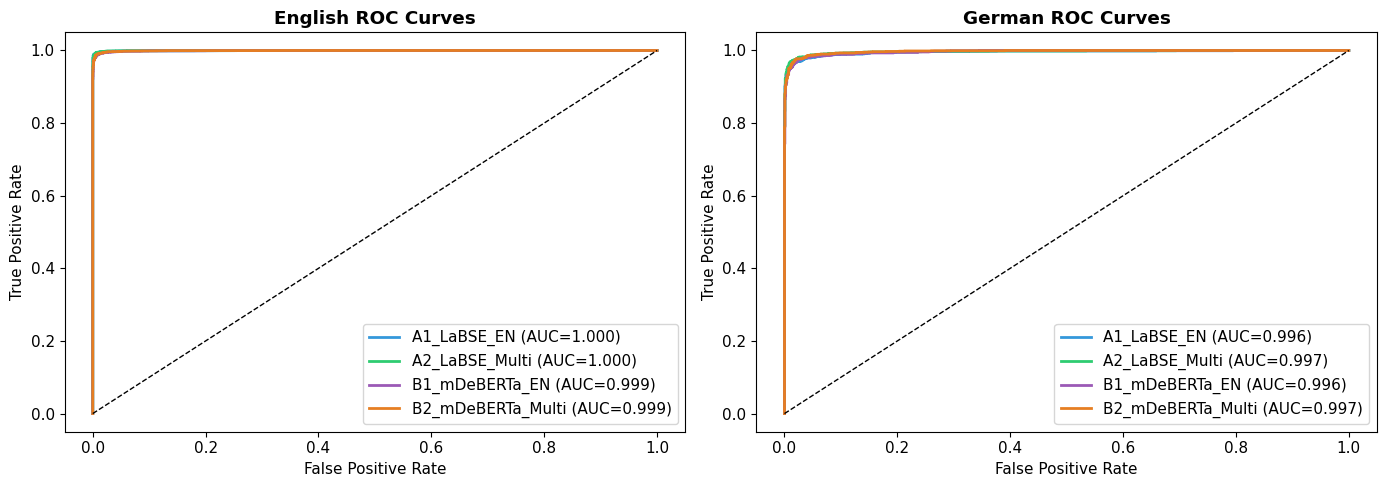

In [26]:
# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']

for lang_idx, (test_df, lang_name) in enumerate([(test_en, 'English'), (test_de, 'German')]):
    ax = axes[lang_idx]
    for i, (name, model, tok, _) in enumerate(exps):
        _, _, labels, probs = evaluate(model, tok, test_df, return_probs=True)
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=colors[i], linewidth=2, label=f'{name} (AUC={roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{lang_name} ROC Curves', fontweight='bold')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/figures/roc_curves.png', dpi=200)
plt.show()

Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM
Tokenizing 10,000 samples...
Loaded to RAM
Tokenizing 3,000 samples...
Loaded to RAM


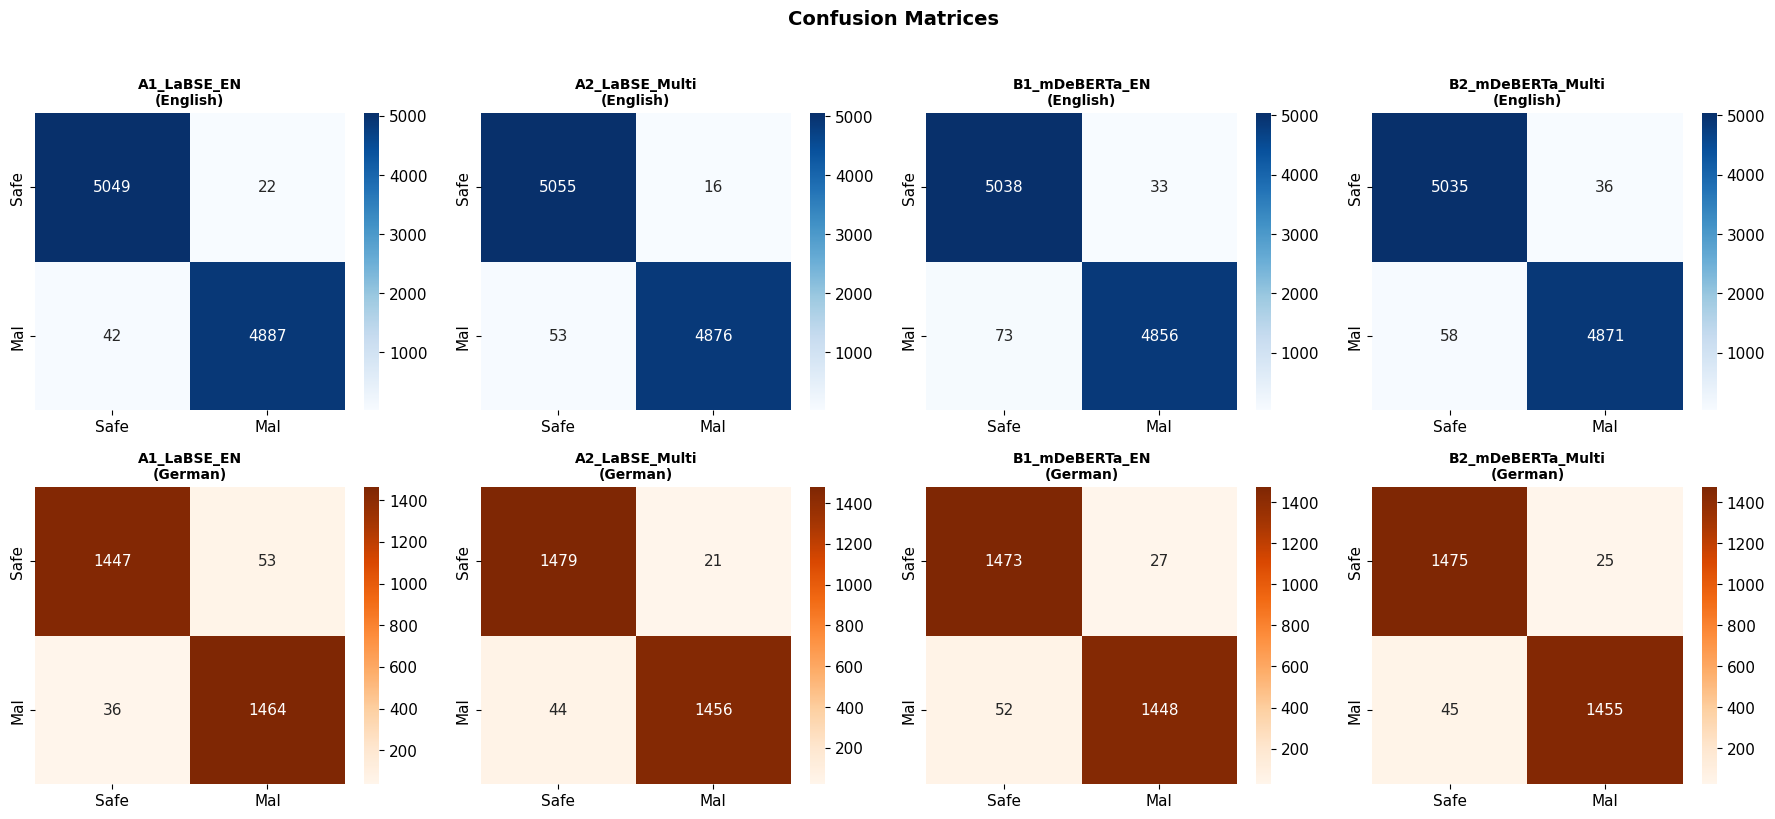

In [27]:
# Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for i, (name, model, tok, _) in enumerate(exps):
    # English
    _, en_preds, en_labels = evaluate(model, tok, test_en)
    cm_en = confusion_matrix(en_labels, en_preds)
    sns.heatmap(cm_en, annot=True, fmt='d', cmap='Blues', ax=axes[0, i], xticklabels=['Safe', 'Mal'], yticklabels=['Safe', 'Mal'])
    axes[0, i].set_title(f'{name}\n(English)', fontsize=10, fontweight='bold')
    
    # German
    _, de_preds, de_labels = evaluate(model, tok, test_de)
    cm_de = confusion_matrix(de_labels, de_preds)
    sns.heatmap(cm_de, annot=True, fmt='d', cmap='Oranges', ax=axes[1, i], xticklabels=['Safe', 'Mal'], yticklabels=['Safe', 'Mal'])
    axes[1, i].set_title(f'{name}\n(German)', fontsize=10, fontweight='bold')

plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/figures/confusion_matrices.png', dpi=200)
plt.show()

---
## Phase 8: Error Analysis
---

In [28]:
# Best model analysis
best_idx = results_df['Avg_F1'].idxmax()
best_name = results_df.loc[best_idx, 'Model']
best_model = exps[best_idx][1]
best_tok = exps[best_idx][2]

print(f'Best Model: {best_name}')

# Get predictions
_, en_preds, en_labels, en_probs = evaluate(best_model, best_tok, test_en, return_probs=True)
test_en_analysis = test_en.copy()
test_en_analysis['predicted'] = en_preds
test_en_analysis['true_label'] = en_labels
test_en_analysis['prob'] = en_probs
test_en_analysis['correct'] = test_en_analysis['predicted'] == test_en_analysis['true_label']

# Error summary
fp = len(test_en_analysis[(test_en_analysis['true_label'] == 0) & (test_en_analysis['predicted'] == 1)])
fn = len(test_en_analysis[(test_en_analysis['true_label'] == 1) & (test_en_analysis['predicted'] == 0)])
print(f'\nErrors:')
print(f'  False Positives: {fp}')
print(f'  False Negatives: {fn}')
print(f'  Error Rate: {(fp + fn) / len(test_en_analysis) * 100:.2f}%')

Best Model: A2_LaBSE_Multi
Tokenizing 10,000 samples...
Loaded to RAM

Errors:
  False Positives: 16
  False Negatives: 53
  Error Rate: 0.69%


---
## Phase 9: Visualizations
---

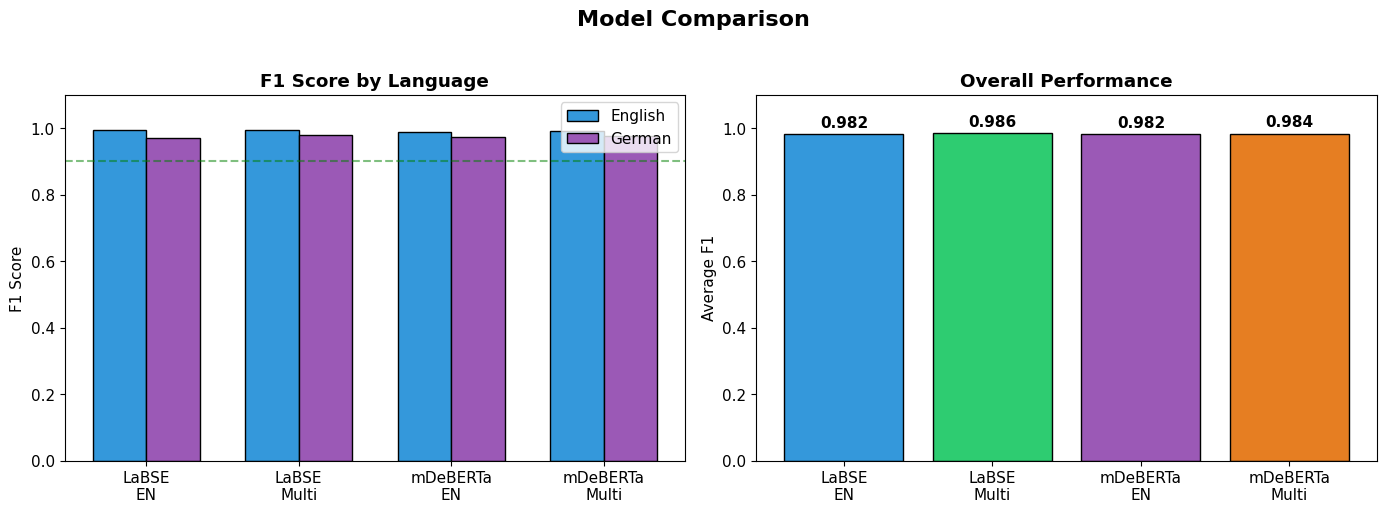

In [29]:
# Results comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(4)
w = 0.35
labels = ['LaBSE\nEN', 'LaBSE\nMulti', 'mDeBERTa\nEN', 'mDeBERTa\nMulti']

# F1 by language
axes[0].bar(x - w/2, results_df['EN_F1'], w, label='English', color='#3498db', edgecolor='black')
axes[0].bar(x + w/2, results_df['DE_F1'], w, label='German', color='#9b59b6', edgecolor='black')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score by Language', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].axhline(0.9, color='green', linestyle='--', alpha=0.5)

# Average F1
bars = axes[1].bar(x, results_df['Avg_F1'], color=colors, edgecolor='black')
for bar, val in zip(bars, results_df['Avg_F1']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center', fontweight='bold')
axes[1].set_ylabel('Average F1')
axes[1].set_title('Overall Performance', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylim(0, 1.1)

plt.suptitle('Model Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/figures/results_comparison.png', dpi=300)
plt.show()

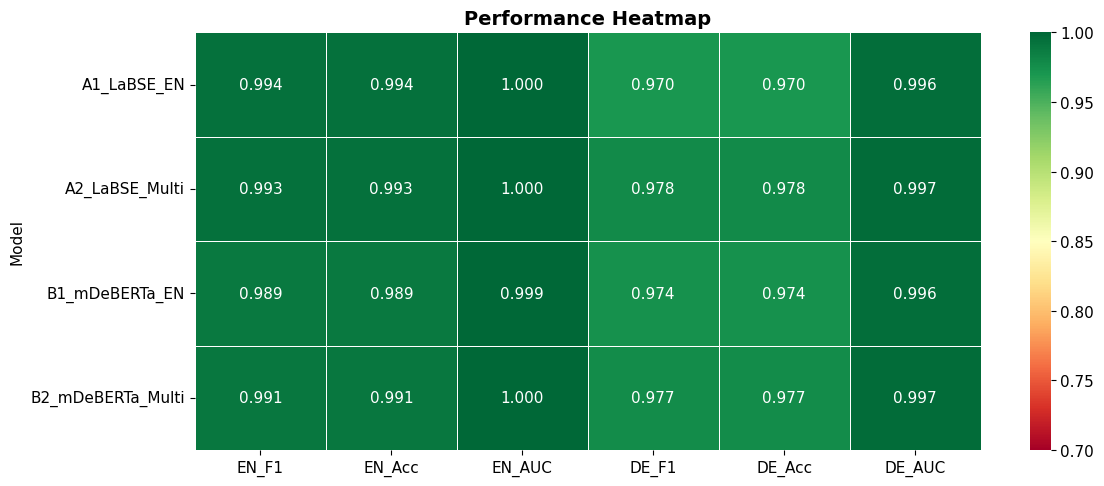

In [30]:
# Heatmap
heatmap_data = results_df[['Model', 'EN_F1', 'EN_Acc', 'EN_AUC', 'DE_F1', 'DE_Acc', 'DE_AUC']].set_index('Model')
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', linewidths=0.5, vmin=0.7, vmax=1.0)
plt.title('Performance Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/figures/heatmap.png', dpi=200)
plt.show()

---
## Phase 10: Final Summary
---

In [31]:
# Export models
print('Creating models.zip...')
shutil.make_archive(f'{SAVE_DIR}/models_export', 'zip', f'{SAVE_DIR}/models')
print(f'Created: {SAVE_DIR}/models_export.zip')
print(f'Size: {os.path.getsize(f"{SAVE_DIR}/models_export.zip")/1e9:.2f} GB')

Creating models.zip...
Created: /kaggle/working/PolyLinguaGuard/models_export.zip
Size: 5.16 GB


In [32]:
# Final summary
best = results_df.loc[results_df['Avg_F1'].idxmax()]
total_time = t1 + t2 + t3 + t4 + trans_time

print('='*60)
print('POLYLINGUAGUARD - COMPLETE')
print('='*60)
print(f'\nBest Model: {best["Model"]}')
print(f'Average F1: {best["Avg_F1"]:.4f}')
print(f'English F1: {best["EN_F1"]:.4f}')
print(f'German F1:  {best["DE_F1"]:.4f}')
print(f'\nTotal Time: {timedelta(seconds=int(total_time))}')
print(f'\nOutput: {SAVE_DIR}')
print('\nDownload models_export.zip from Output tab')

POLYLINGUAGUARD - COMPLETE

Best Model: A2_LaBSE_Multi
Average F1: 0.9857
English F1: 0.9931
German F1:  0.9783

Total Time: 2:52:10

Output: /kaggle/working/PolyLinguaGuard

Download models_export.zip from Output tab


In [33]:
# List saved files
print('\nSaved Files:')
for root, dirs, files in os.walk(SAVE_DIR):
    level = root.replace(SAVE_DIR, '').count(os.sep)
    indent = '  ' * level
    print(f'{indent}{os.path.basename(root)}/')
    for f in files[:5]:
        print(f'{indent}  {f}')


Saved Files:
PolyLinguaGuard/
  models_export.zip
  results.csv
  models/
    A2_LaBSE_Multi/
      vocab.txt
      special_tokens_map.json
      config.json
      tokenizer_config.json
      tokenizer.json
    B2_mDeBERTa_Multi/
      special_tokens_map.json
      spm.model
      config.json
      tokenizer_config.json
      added_tokens.json
    A1_LaBSE_EN/
      vocab.txt
      special_tokens_map.json
      config.json
      tokenizer_config.json
      tokenizer.json
    B1_mDeBERTa_EN/
      special_tokens_map.json
      spm.model
      config.json
      tokenizer_config.json
      added_tokens.json
  data/
    test_de.csv
    german_translated.csv
    test_en.csv
  figures/
    heatmap.png
    confusion_matrices.png
    results_comparison.png
    roc_curves.png
